# Importing Libraries

In [1]:
import os
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import re,string,unicodedata

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from scikitplot.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import transformers
import tokenizers

# Data Extraction and Cleaning

In [2]:
import pandas as pd
df = pd.read_csv('IMDBDataset.csv')
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production.  The filming te...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


In [4]:
print(df.describe())

                                                   review sentiment
count                                               50000     50000
unique                                              49672         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000


In [5]:
print(df.isnull().sum()) #identifying missing values

review       0
sentiment    0
dtype: int64


In [6]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [7]:
df.fillna(0, inplace=True) 

In [8]:
df.shape

(50000, 2)

In [9]:
num_duplicates = df.duplicated().sum() #identify duplicates
print('There are {} duplicate reviews present in the dataset'.format(num_duplicates))

There are 328 duplicate reviews present in the dataset


In [10]:
#view duplicate reviews
review = df['review']
duplicated_review = df[review.isin(review[review.duplicated()])].sort_values("review")
duplicated_review.head()

review sentiment
13413   Back in his youth, the old man had wanted to ...  negative
15849   Back in his youth, the old man had wanted to ...  negative
24178   First of all, I reviewed this documentary bec...  positive
25784   First of all, I reviewed this documentary bec...  positive
32926   Summary: Not worth the film As an avid Gone W...  negative

In [11]:
df.drop_duplicates(inplace=True)#drop duplicates

In [12]:
df.shape

(49672, 2)

In [13]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sejal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
df['review'] = df['review'].apply(lambda x: x.lower())  
df['review'] = df['review'].apply(lambda x: word_tokenize(x)) 
display(df)

review sentiment
0      [one, of, the, other, reviewers, has, mentione...  positive
1      [a, wonderful, little, production, ., the, fil...  positive
2      [i, thought, this, was, a, wonderful, way, to,...  positive
3      [basically, there, 's, a, family, where, a, li...  negative
4      [petter, mattei, 's, ``, love, in, the, time, ...  positive
...                                                  ...       ...
49995  [i, thought, this, movie, did, a, down, right,...  positive
49996  [bad, plot, ,, bad, dialogue, ,, bad, acting, ...  negative
49997  [i, am, a, catholic, taught, in, parochial, el...  negative
49998  [i, 'm, going, to, have, to, disagree, with, t...  negative
49999  [no, one, expects, the, star, trek, movies, to...  negative

[49672 rows x 2 columns]

In [15]:
os.environ["NLTK_DATA"] = "https://nltk.org/nltk_data/"
df['review'] = df['review'].apply(lambda x: [re.sub(r'[^a-zA-Z]', '', word) for word in x])
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['review'] = df['review'].apply(lambda x: [word for word in x if word not in stop_words])
stemmer = PorterStemmer()
df['review'] = df['review'].apply(lambda x: [stemmer.stem(word) for word in x])
df['review'] = df['review'].apply(lambda x: ' '.join(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sejal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
#converting target variable to numeric labels
df.sentiment = [ 1 if each == "positive" else 0 for each in df.sentiment]
#after converting labels
df.head()


review  sentiment
0  one review mention watch  oz episod hook  righ...          1
1  wonder littl product  film techniqu unassum ol...          1
2  thought wonder way spend time hot summer weeke...          1
3  basic famili littl boy  jake  think zombi clos...          0
4  petter mattei  love time money  visual stun fi...          1

# Exploratory data analysis

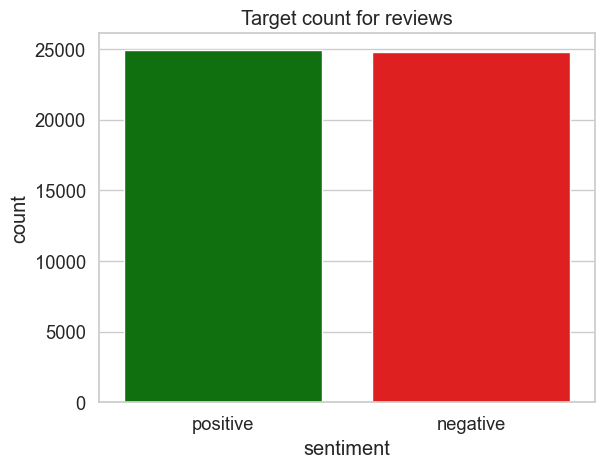

In [17]:
### Count Plot
sns.set(style = "whitegrid" , font_scale = 1.2)
sns.countplot(x=df.sentiment,palette = ['green','red'],order = [1,0])
plt.xticks(ticks = np.arange(2),labels = ['positive','negative'])
plt.title('Target count for reviews')
plt.show()

In [18]:
print('Positive reviews are', (round(df['sentiment'].value_counts()[0])),'i.e.', round(df['sentiment'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Negative reviews are', (round(df['sentiment'].value_counts()[1])),'i.e.',round(df['sentiment'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

Positive reviews are 24764 i.e. 49.86 % of the dataset
Negative reviews are 24908 i.e. 50.14 % of the dataset


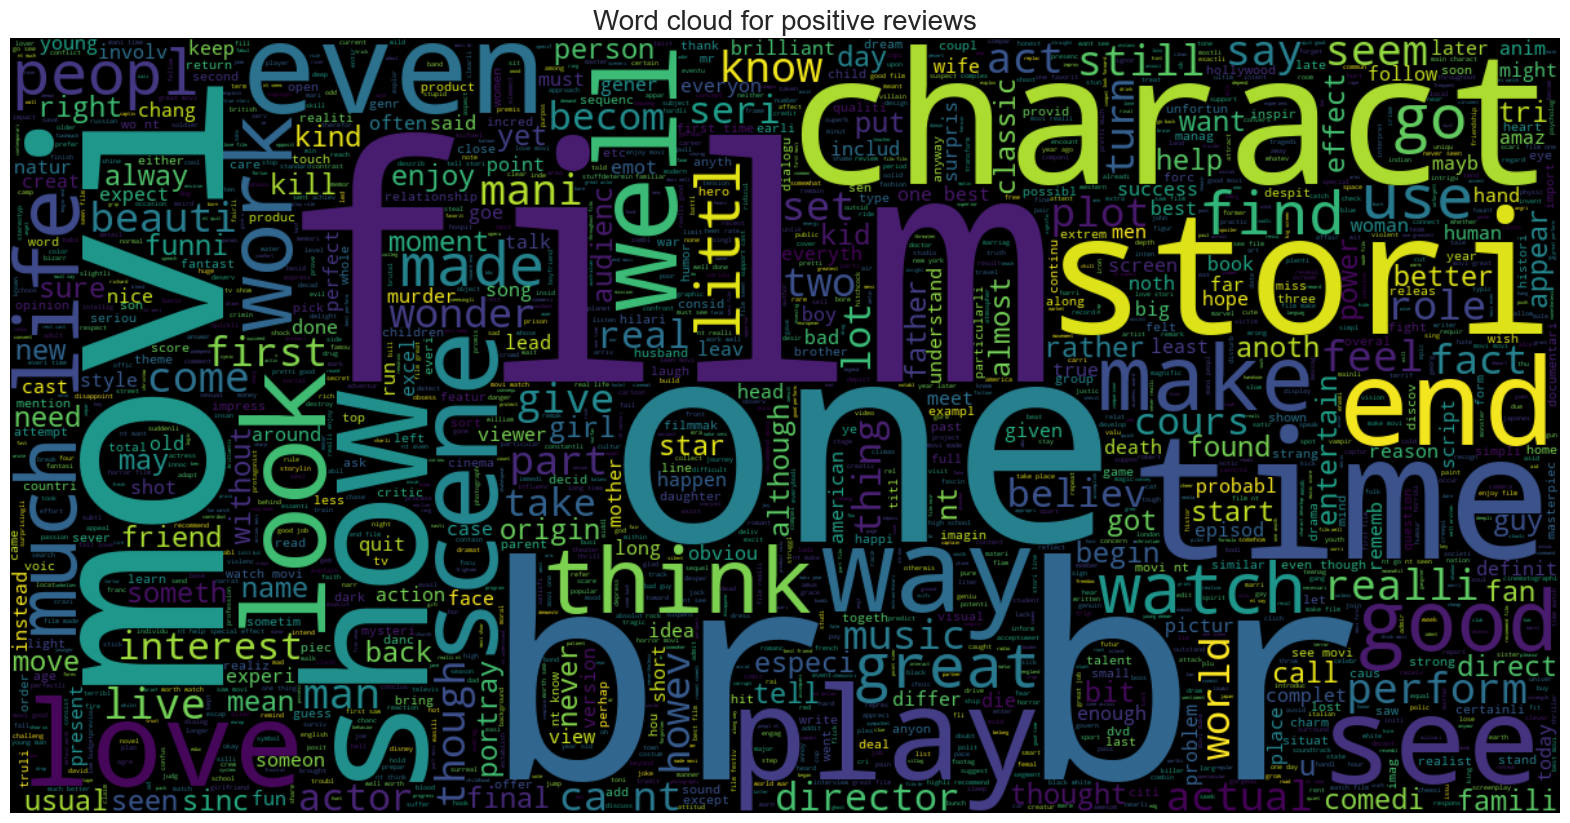

In [19]:
#word cloud for positive reviews
positive_data = df[df.sentiment == 1]['review']
positive_data_string = ' '.join(positive_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="black").generate(positive_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for positive reviews',fontsize = 20)
plt.show()

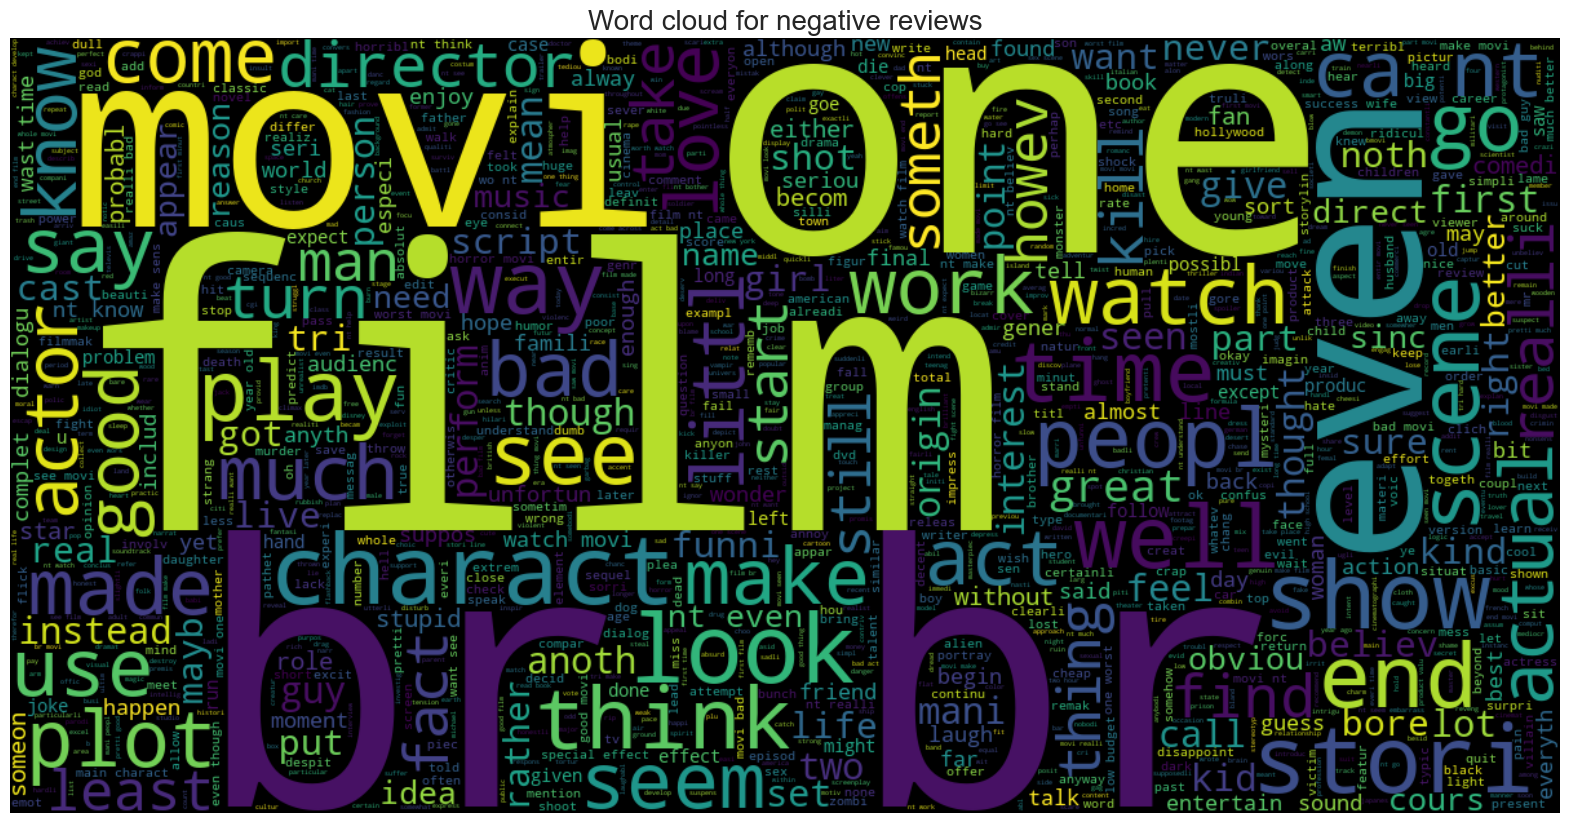

In [20]:
#word cloud for negative reviews
negative_data = df[df.sentiment == 0]['review']
negative_data_string = ' '.join(negative_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="black").generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for negative reviews',fontsize = 20)
plt.show()

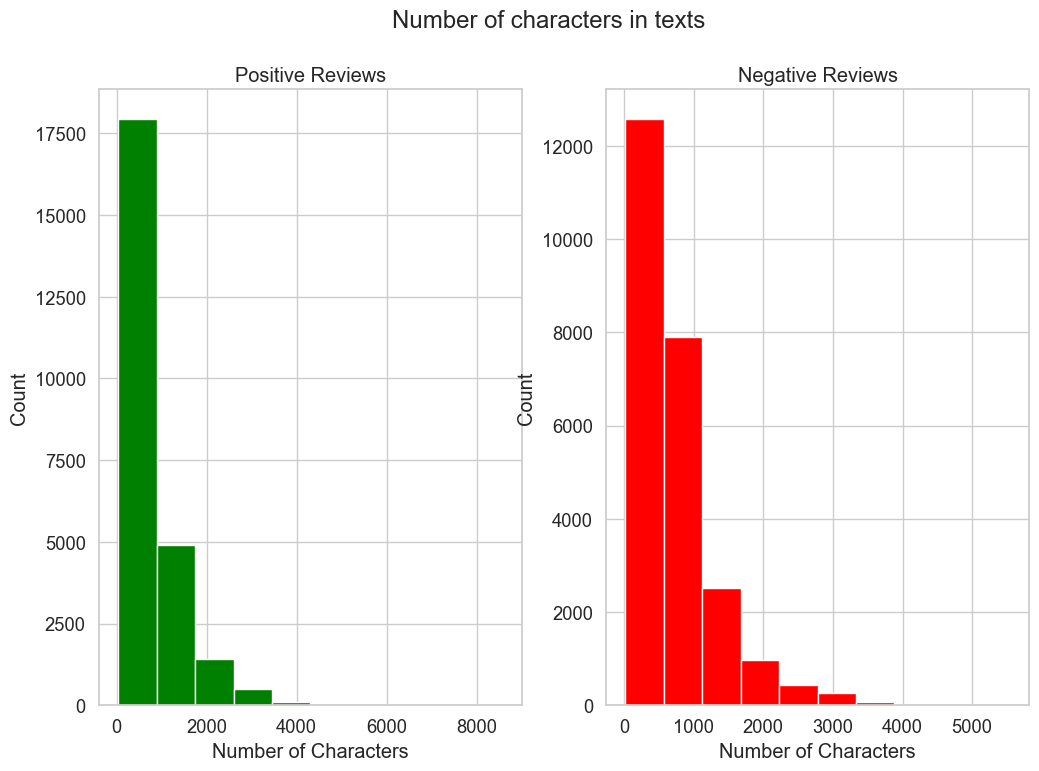

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
positive_data = df[df.sentiment == 1]['review']
negative_data = df[df.sentiment == 0]['review']
text_len=positive_data.str.len()
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Characters')
ax1.set_ylabel('Count')
text_len=negative_data.str.len()
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Characters')
ax2.set_ylabel('Count')
fig.suptitle('Number of characters in texts')
plt.show()

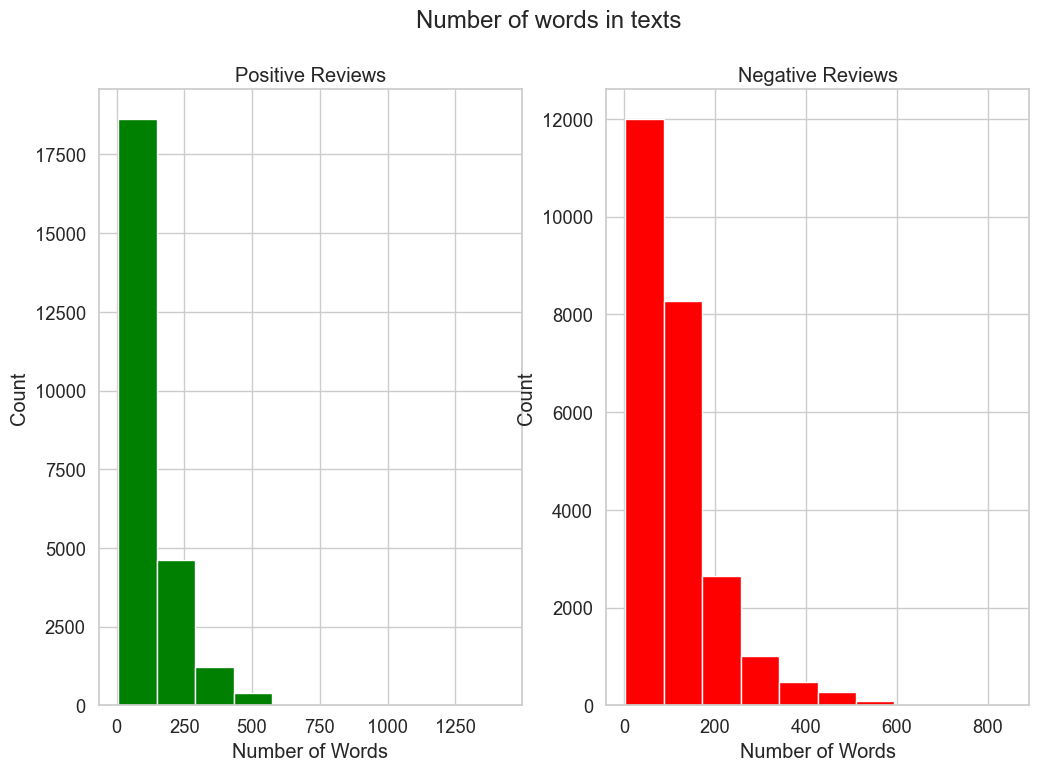

In [22]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=positive_data.str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of Words')
ax1.set_ylabel('Count')
text_len=negative_data.str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Count')
fig.suptitle('Number of words in texts')
plt.show()

C:\Users\sejal\AppData\Local\Temp\ipykernel_19912\3932708398.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word, ax=ax1,color='green')
C:\Users\sejal\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sejal\AppData\Local\Temp\ipykernel_19912\3932708398.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
simil

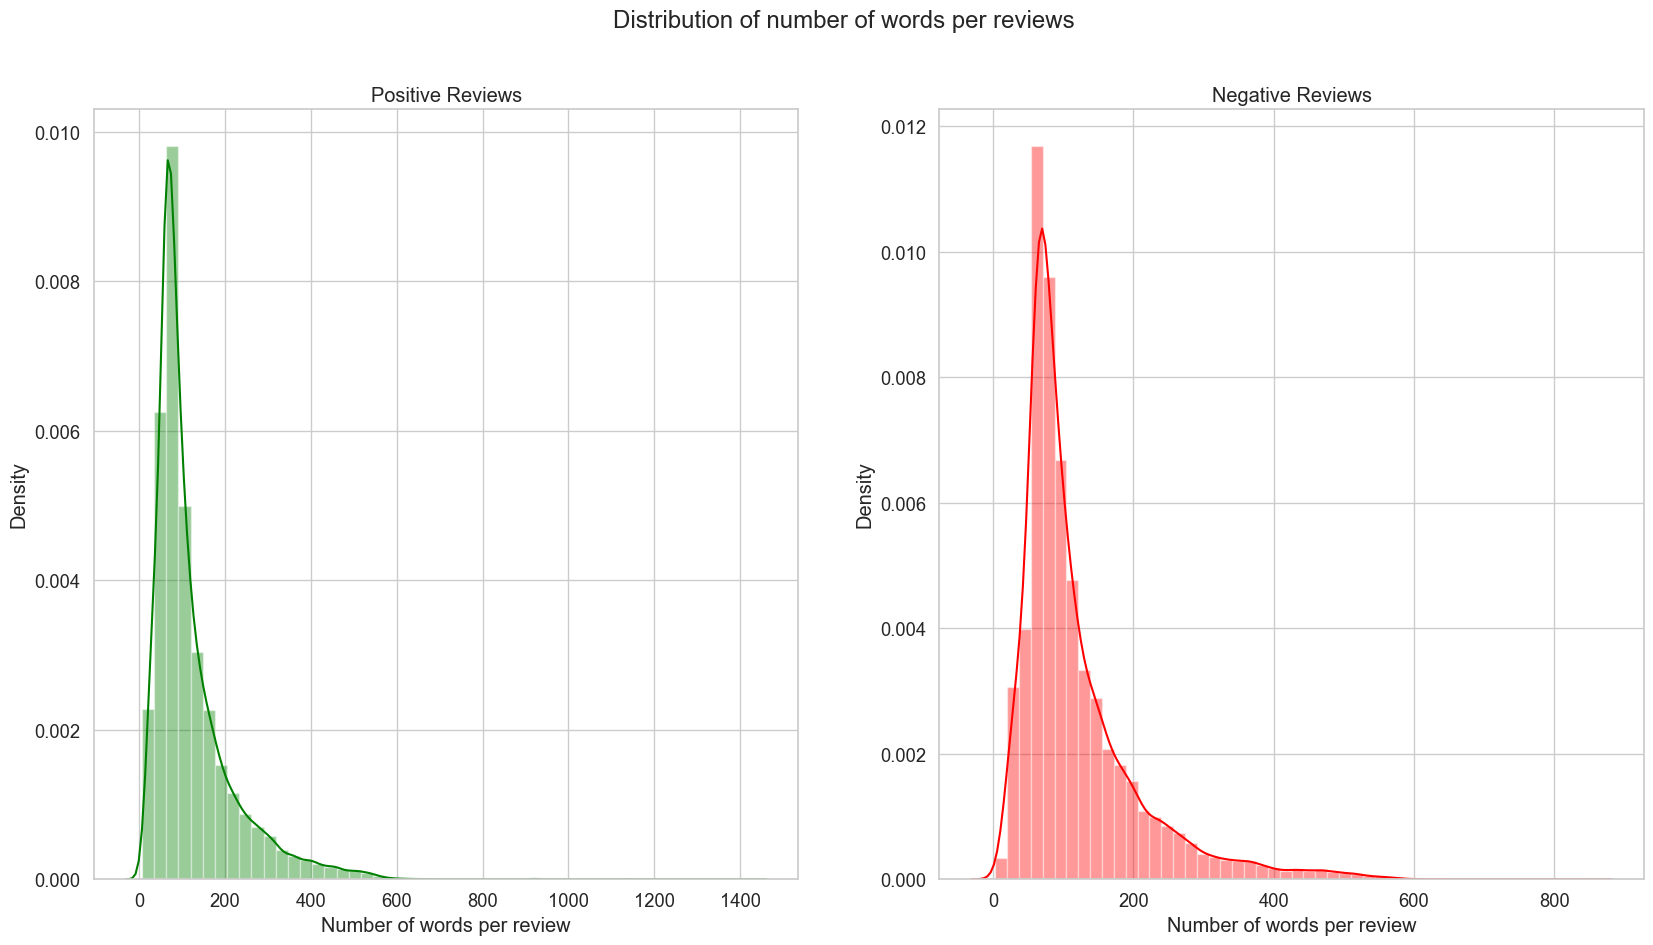

In [23]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = positive_data.str.split().apply(lambda x : len(x) )
sns.distplot(word, ax=ax1,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Number of words per review')
word = negative_data.str.split().apply(lambda x :len(x) )
sns.distplot(word,ax=ax2,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Number of words per review')
fig.suptitle('Distribution of number of words per reviews')
plt.show()

C:\Users\sejal\AppData\Local\Temp\ipykernel_19912\4290819679.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1,color='green')
C:\Users\sejal\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sejal\AppData\Local\Temp\ipykernel_19912\4290819679.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure

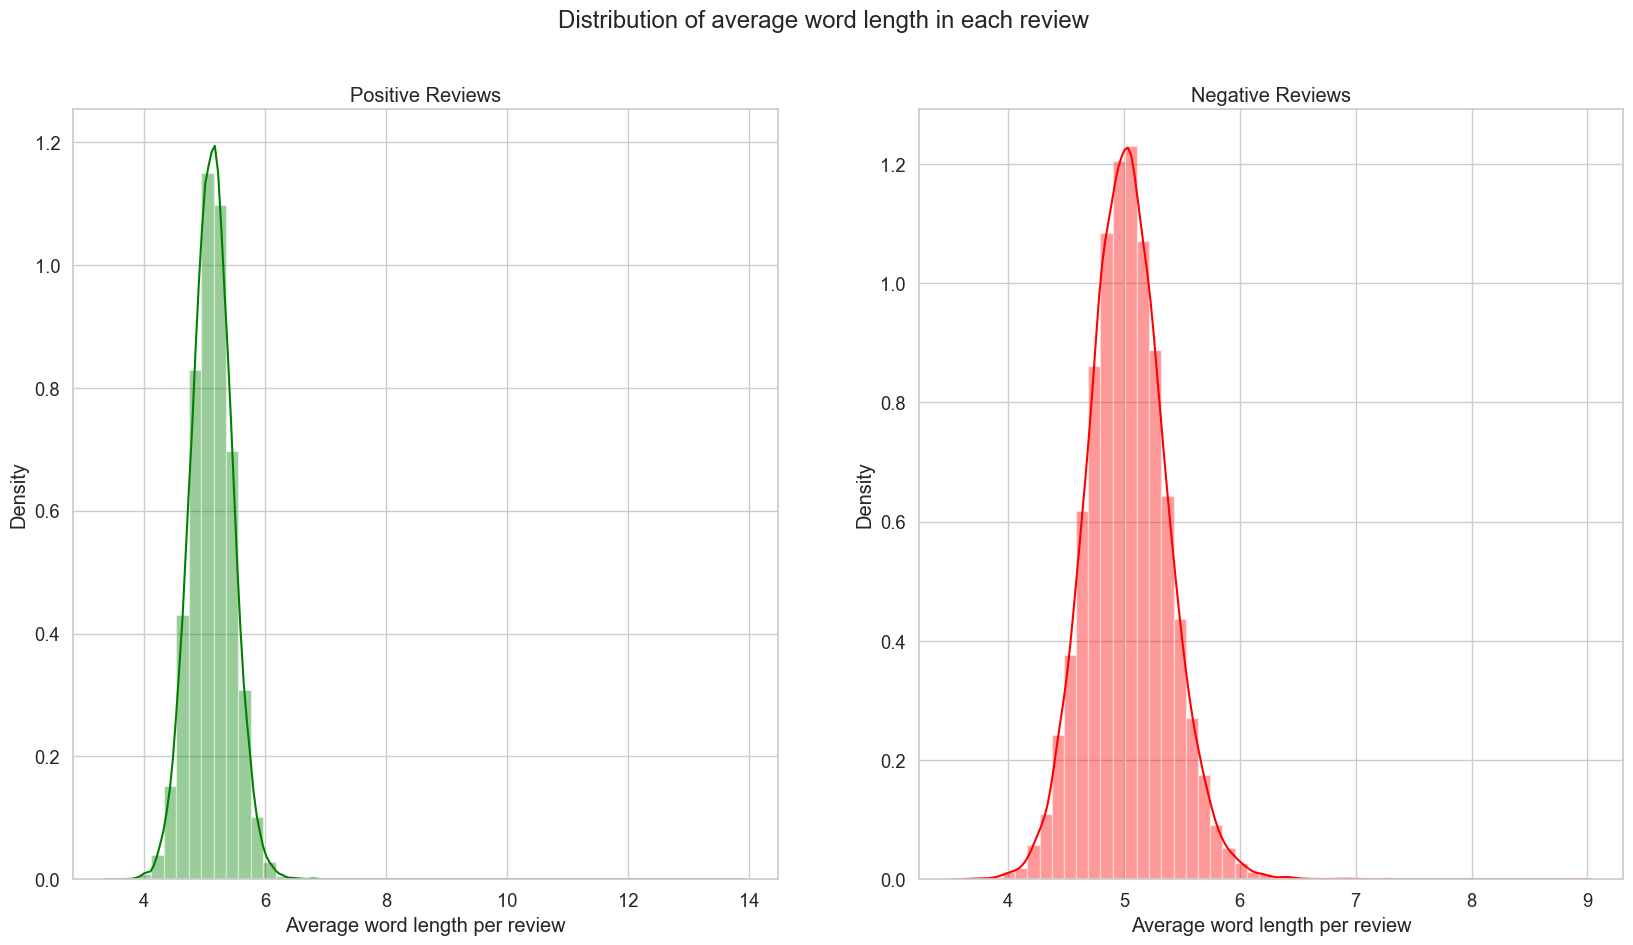

In [24]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word = positive_data.str.split().apply(lambda x : [len(i) for i in x] )
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1,color='green')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('Average word length per review')
word = negative_data.str.split().apply(lambda x : [len(i) for i in x] )
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('Average word length per review')
fig.suptitle('Distribution of average word length in each review')
plt.show()

In [25]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.review)
corpus[:5]


['one', 'review', 'mention', 'watch', 'oz']

In [26]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common,columns = ['corpus','countv'])
most_common

corpus  countv
0     movi  101106
1     film   93995
2       nt   65980
3       br   60914
4      one   53797
5     like   44022
6     time   30724
7     good   29375
8     make   28596
9  charact   27981

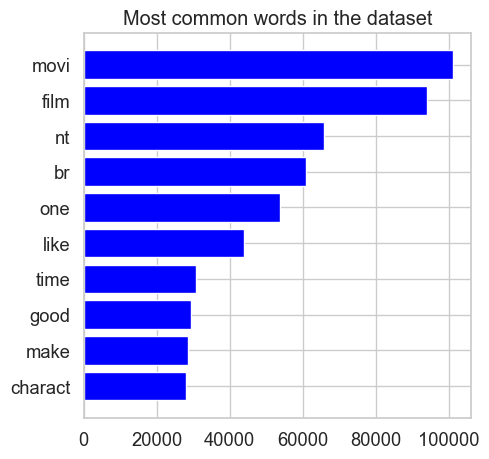

In [27]:
most_common = most_common.sort_values('countv')
plt.figure(figsize =(5,5))
plt.yticks(range(len(most_common)), list(most_common.corpus))
plt.barh(range(len(most_common)), list(most_common.countv),align='center',color = 'blue')
plt.title('Most common words in the dataset')
plt.show()

In [28]:
def get_ngrams(review, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(review)
    bag_of_words = vec.transform(review) #sparse matrix of count_vectorizer
    sum_words = bag_of_words.sum(axis=0) #total number of words
    sum_words = np.array(sum_words)[0].tolist() #convert to list
    words_freq = [(word, sum_words[idx]) for word, idx in vec.vocabulary_.items()] #get word freqency for word location in count vec
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) #key is used to perform sorting using word_freqency 
    return words_freq[:n]

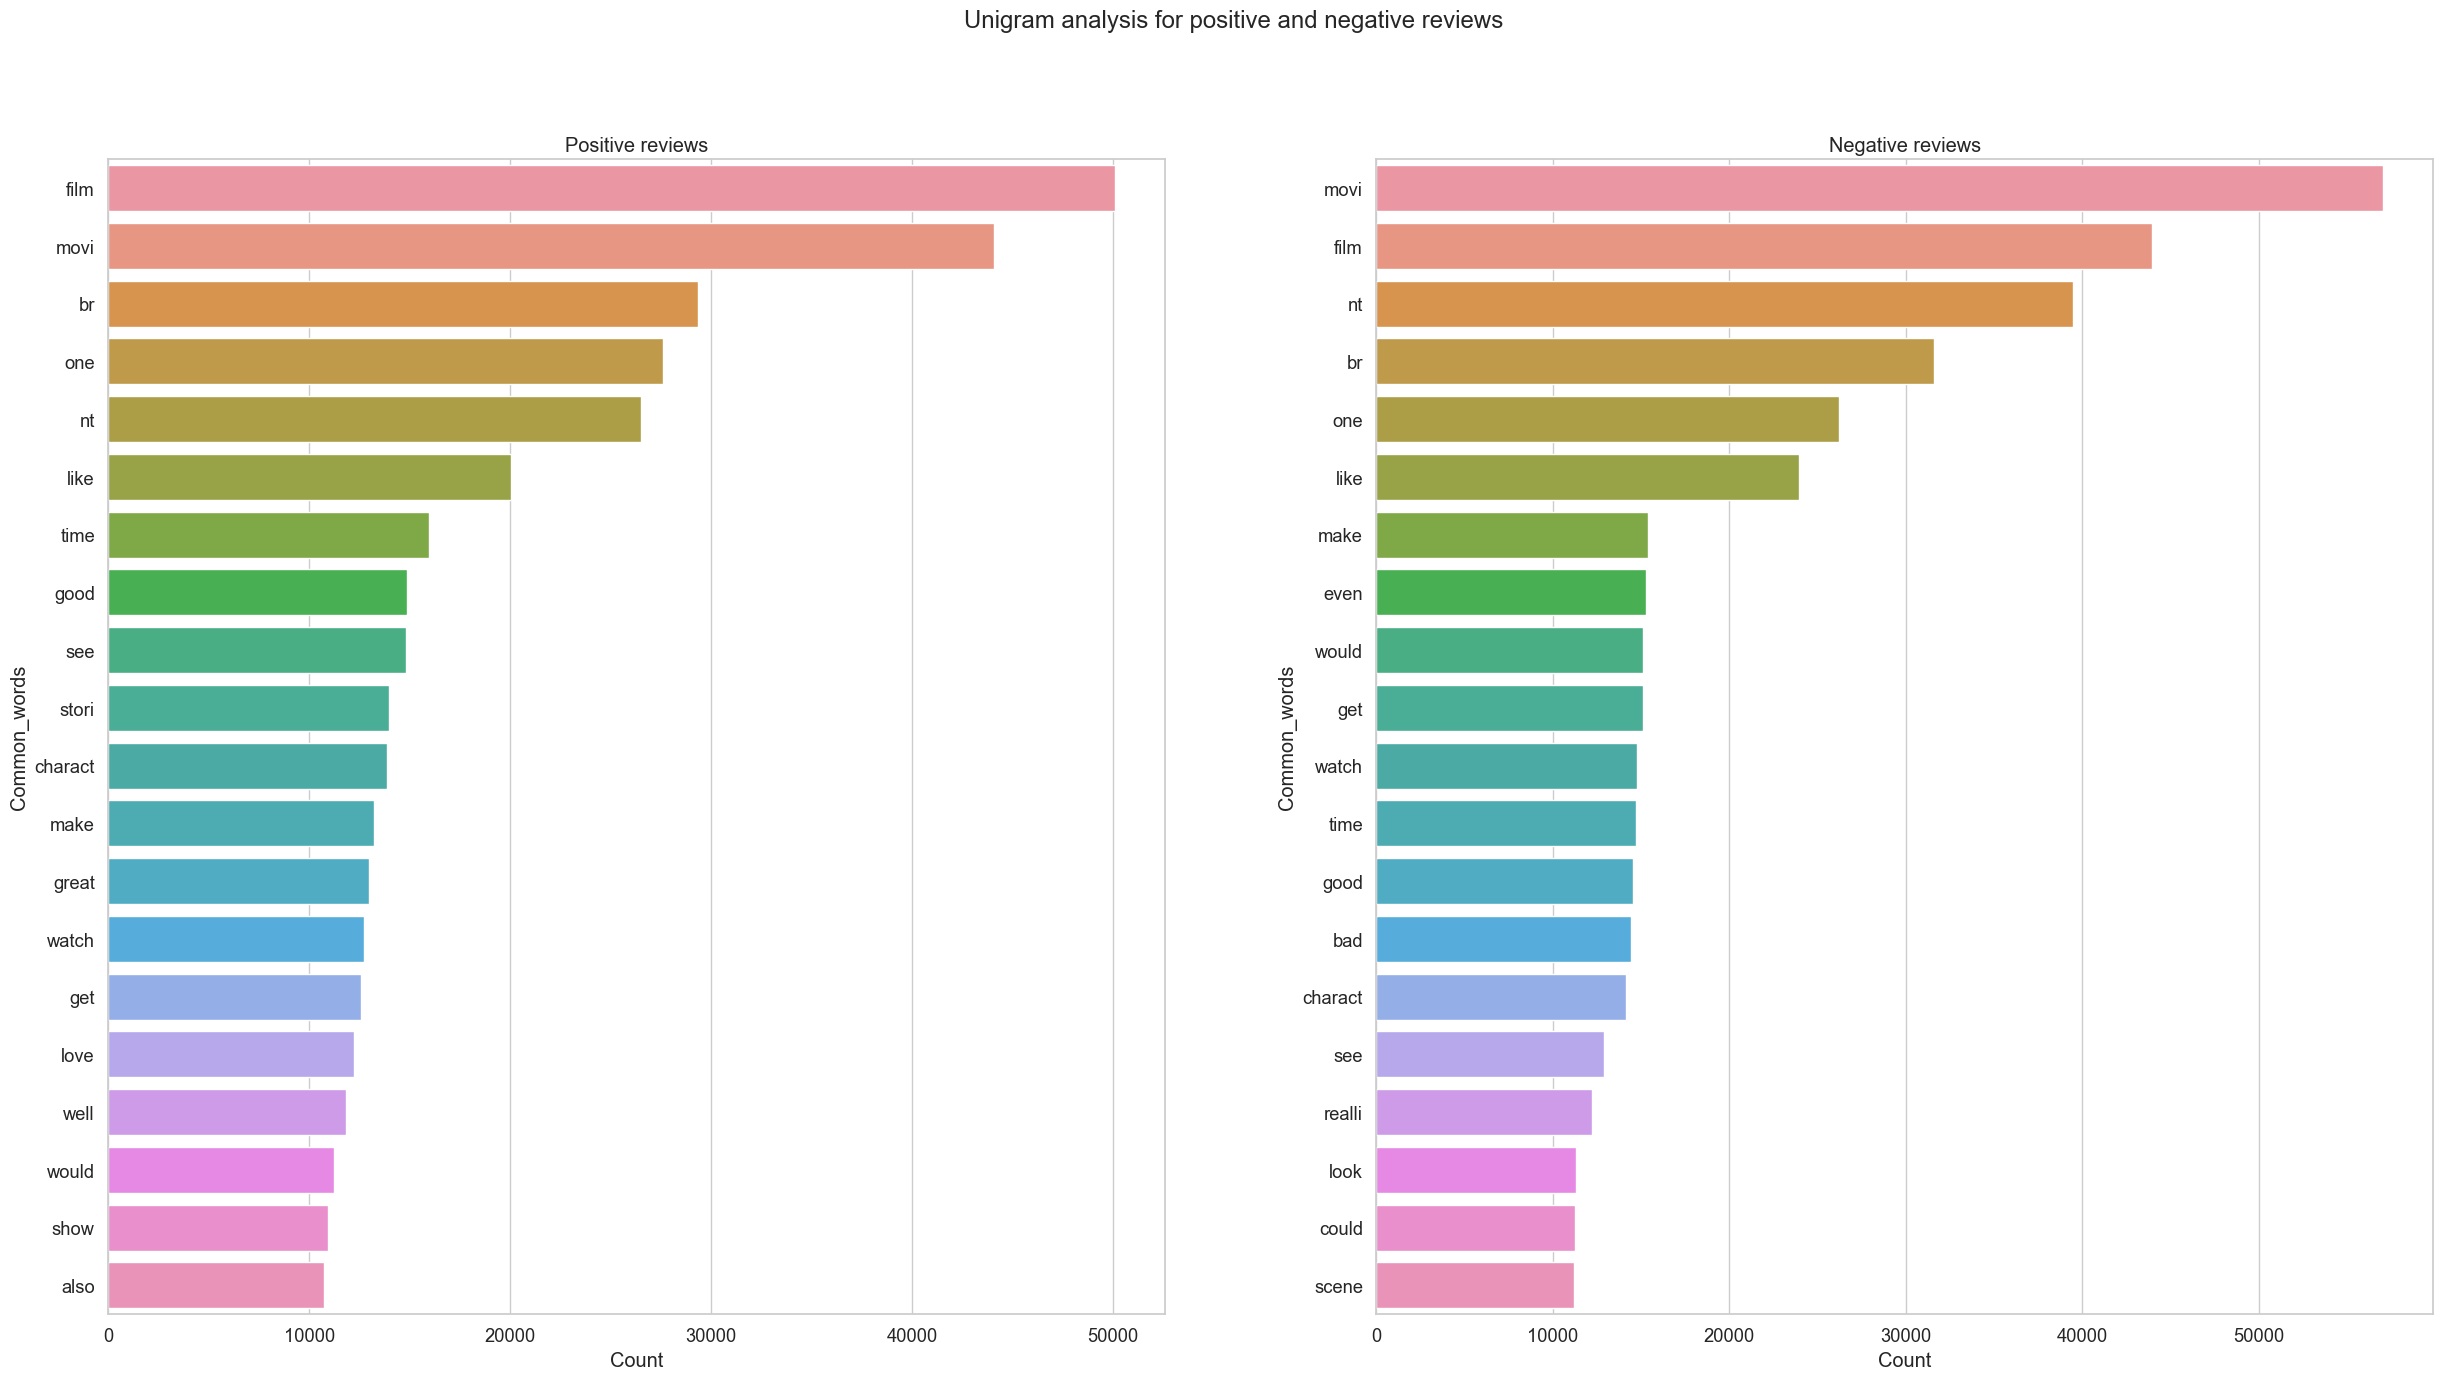

In [29]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
uni_positive = get_ngrams(positive_data,20,1)
uni_positive = dict(uni_positive)
temp = pd.DataFrame(list(uni_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
uni_negative = get_ngrams(negative_data,20,1)
uni_negative = dict(uni_negative)
temp = pd.DataFrame(list(uni_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Unigram analysis for positive and negative reviews')
plt.show()

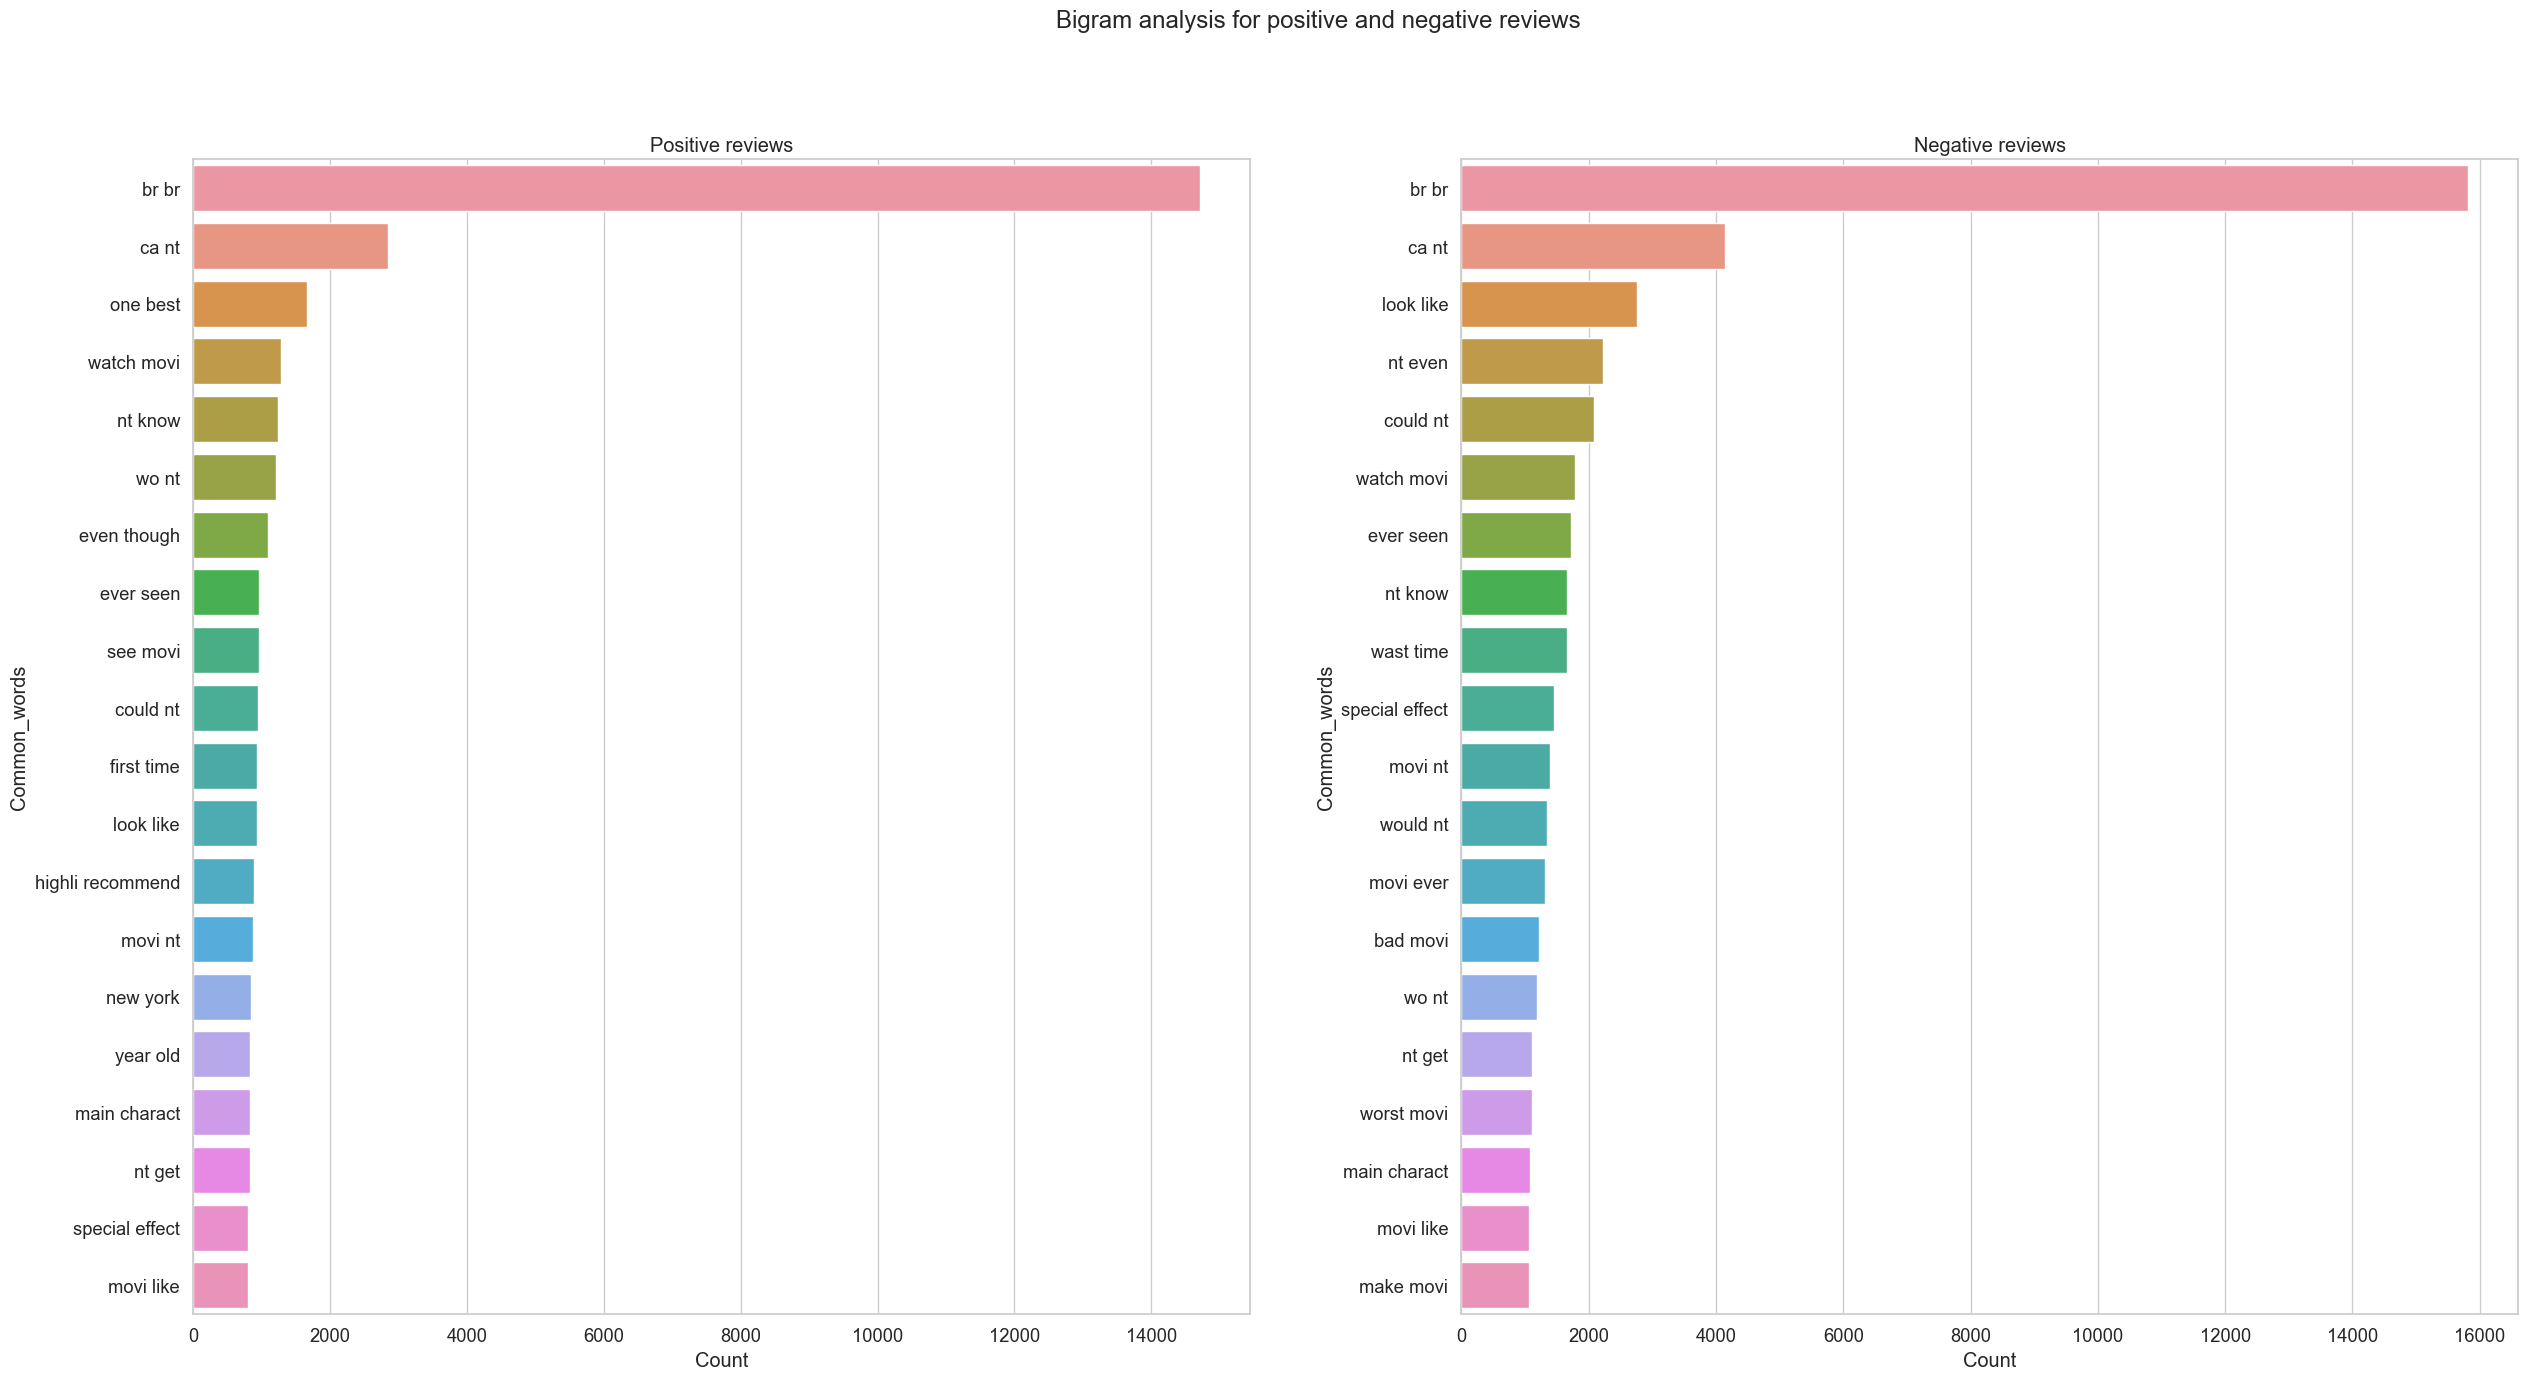

In [30]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
bi_positive = get_ngrams(positive_data,20,2)
bi_positive = dict(bi_positive)
temp = pd.DataFrame(list(bi_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
bi_negative = get_ngrams(negative_data,20,2)
bi_negative = dict(bi_negative)
temp = pd.DataFrame(list(bi_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Bigram analysis for positive and negative reviews')
plt.show()

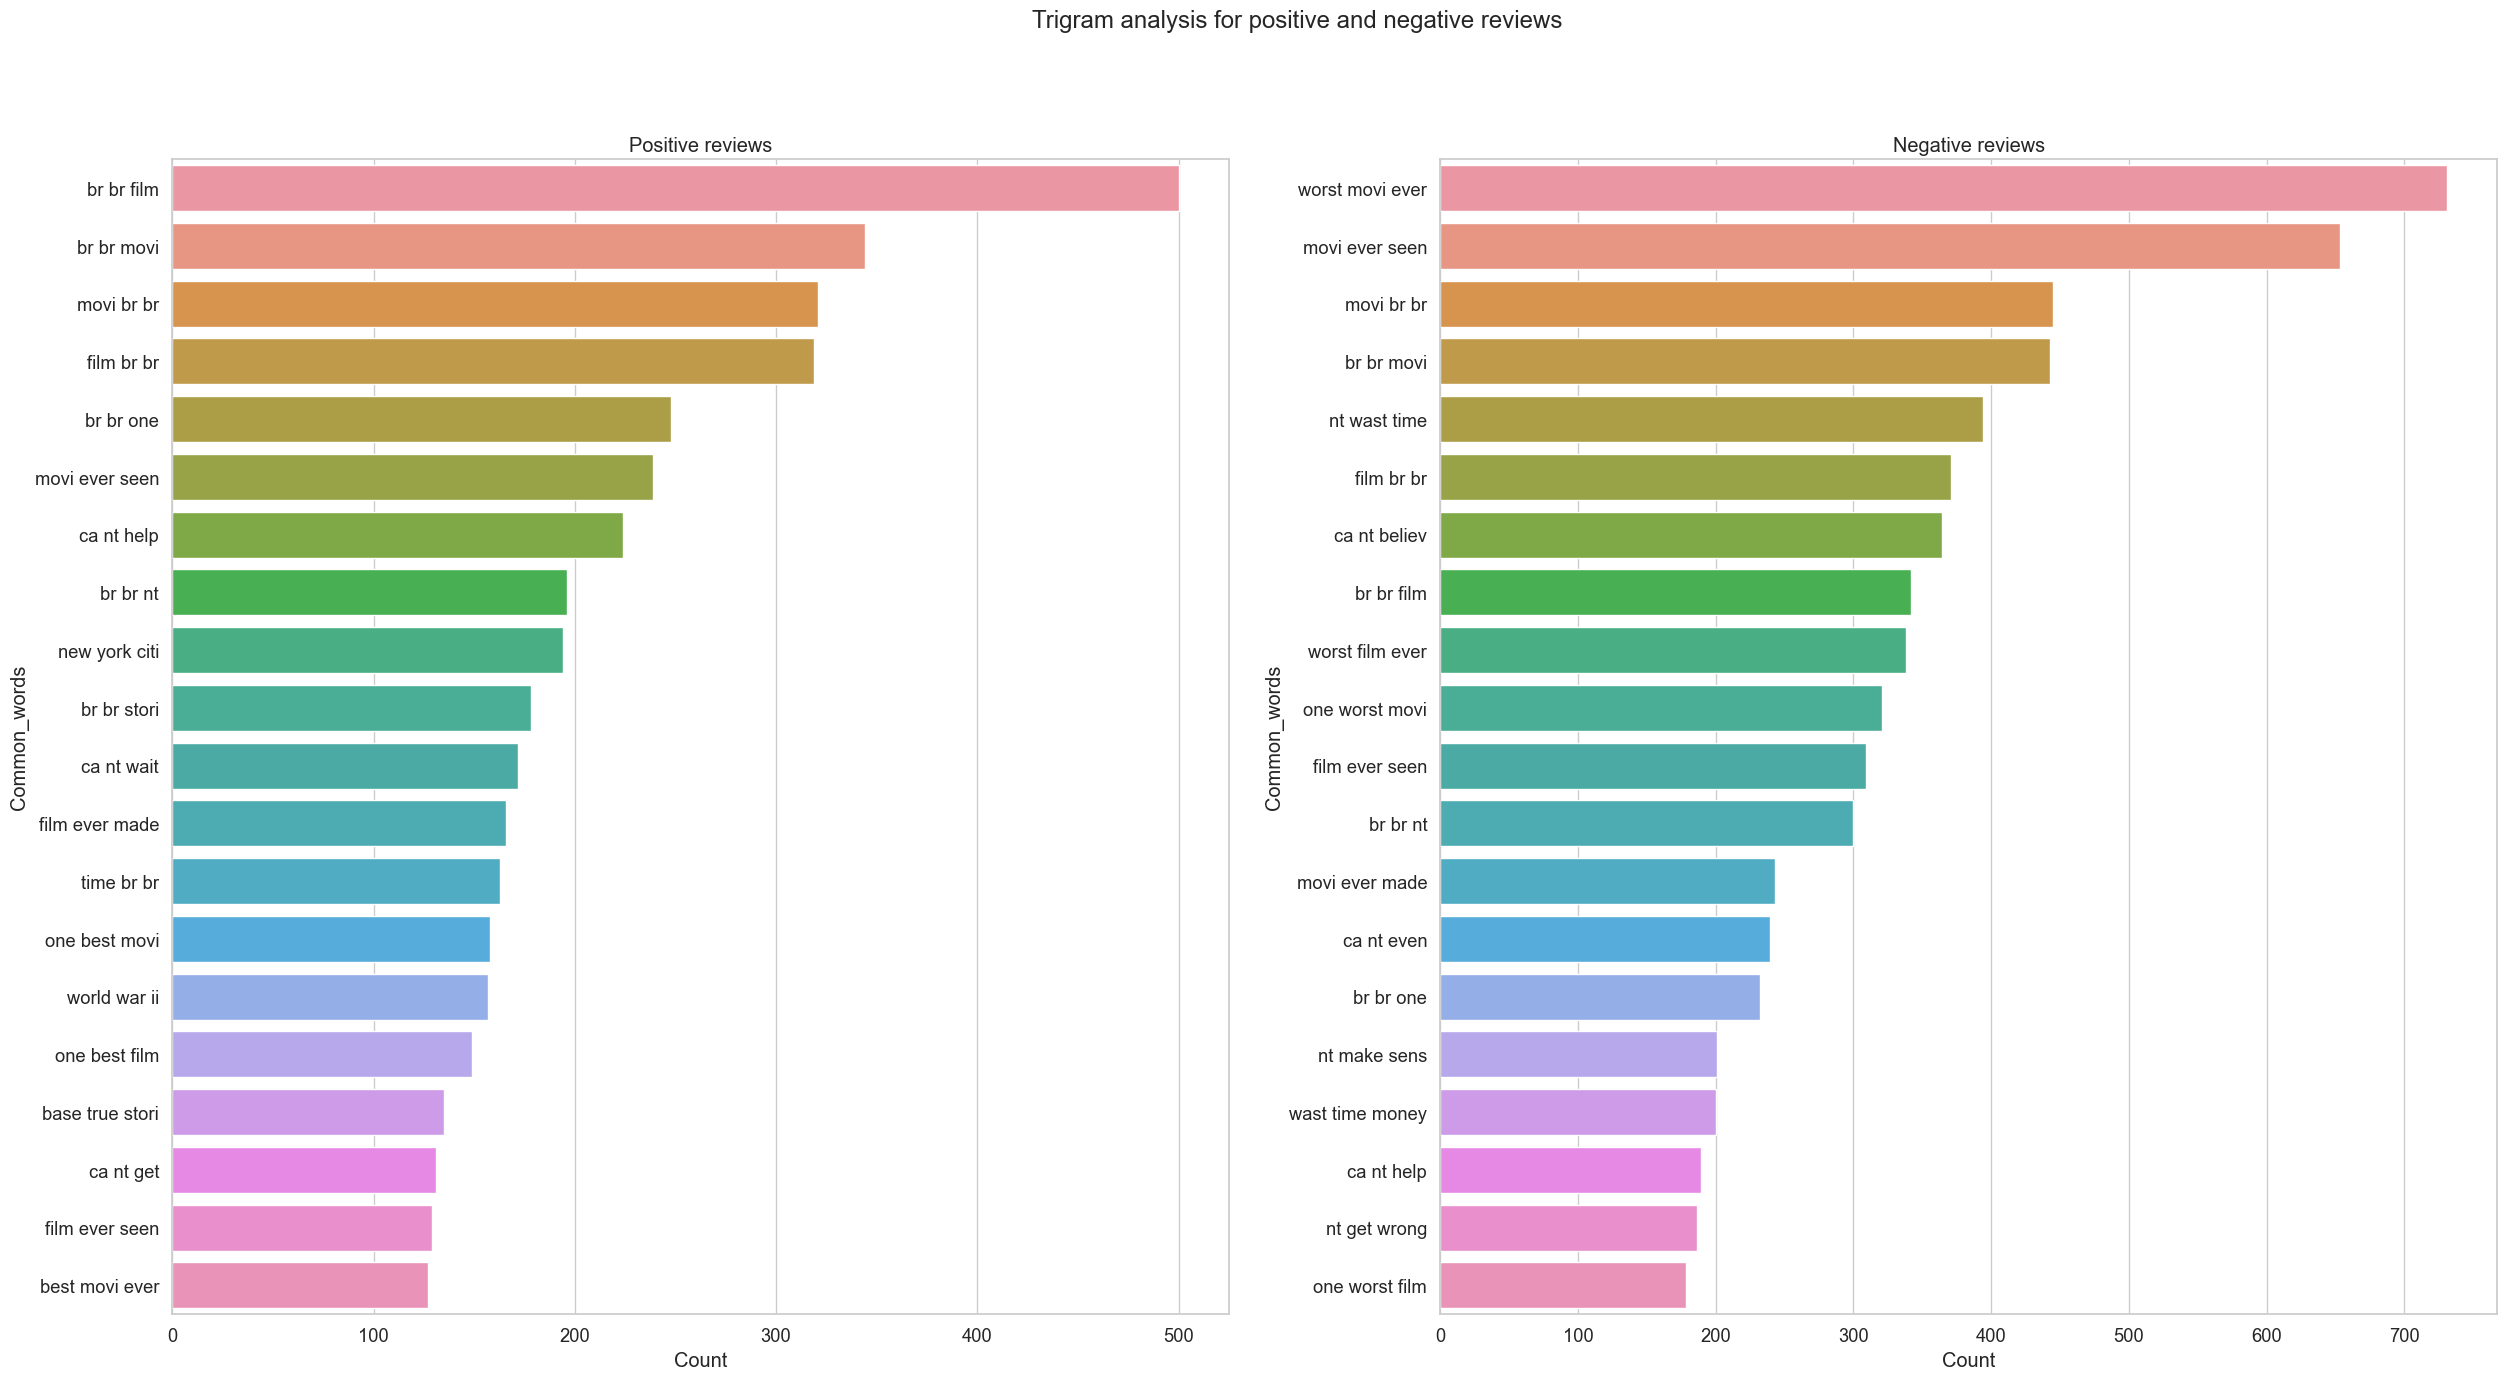

In [31]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(30,15))
tri_positive = get_ngrams(positive_data,20,3)
tri_positive = dict(tri_positive)
temp = pd.DataFrame(list(tri_positive.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax1)
ax1.set_title('Positive reviews')
tri_negative = get_ngrams(negative_data,20,3)
tri_negative = dict(tri_negative)
temp = pd.DataFrame(list(tri_negative.items()), columns = ["Common_words" , 'Count'])
sns.barplot(data = temp, x="Count", y="Common_words", orient='h',ax = ax2)
ax2.set_title('Negative reviews')
fig.suptitle('Trigram analysis for positive and negative reviews')
plt.show()

# Predictive Modelling using Machine Learning

In [75]:
#splitting into train and test
train, test= train_test_split(df, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
Xtest, ytest = test['review'], test['sentiment']

In [76]:
#Vectorizing data

tfidf_vect = TfidfVectorizer() #tfidfVectorizer
Xtrain_tfidf = tfidf_vect.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vect.transform(Xtest)


count_vect = CountVectorizer() # CountVectorizer
Xtrain_count = count_vect.fit_transform(Xtrain)
Xtest_count = count_vect.transform(Xtest)

In [ ]:
LOGISTIC REGRESSION

Logistic Regression Accuracy : 89.39%


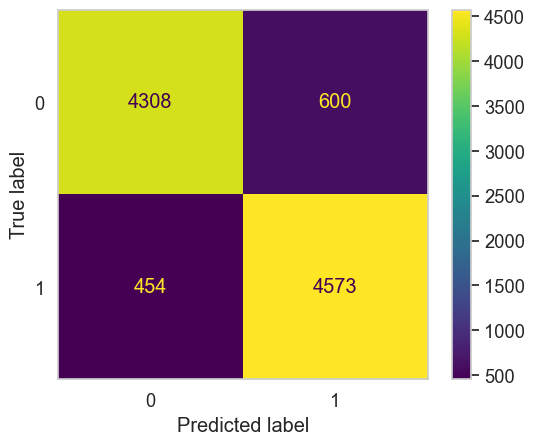

In [81]:



lr = LogisticRegression()
lr.fit(Xtrain_tfidf,ytrain)
p1=lr.predict(Xtest_tfidf)
s1=accuracy_score(ytest,p1)
print("Logistic Regression Accuracy :", "{:.2f}%".format(100*s1))
ConfusionMatrixDisplay.from_estimator(lr,Xtest_tfidf, ytest)
plt.grid(False)

In [ ]:
MULTINOMIAL NAIVE BAYES

Multinomial Naive Bayes Classifier Accuracy : 85.81%


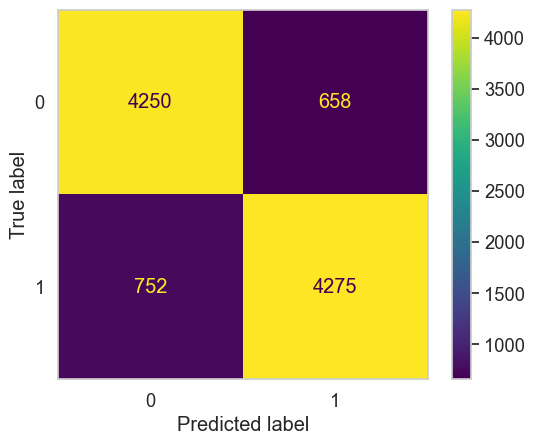

In [82]:
mnb= MultinomialNB()
mnb.fit(Xtrain_tfidf,ytrain)
p2=mnb.predict(Xtest_tfidf)
s2=accuracy_score(ytest,p2)
print("Multinomial Naive Bayes Classifier Accuracy :", "{:.2f}%".format(100*s2))
ConfusionMatrixDisplay.from_estimator(mnb,Xtest_tfidf, ytest)
plt.grid(False)

In [ ]:
LINEAR SVM

Linear Support Vector Classifier Accuracy : 89.35%


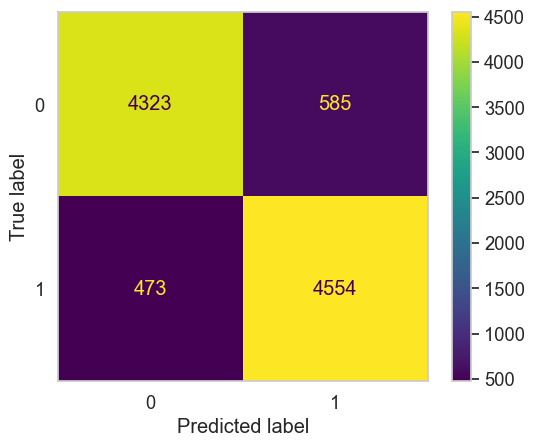

In [83]:
linear_svc = LinearSVC(penalty='l2',loss = 'hinge')
linear_svc.fit(Xtrain_tfidf,ytrain)
p3=linear_svc.predict(Xtest_tfidf)
s3=accuracy_score(ytest,p3)
print("Linear Support Vector Classifier Accuracy :", "{:.2f}%".format(100*s3))
ConfusionMatrixDisplay.from_estimator(linear_svc, Xtest_tfidf, ytest)
plt.grid(False)

# Live Predictions...

In [96]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_vectorized, y_train)
y_pred = naive_bayes_classifier.predict(X_test_vectorized)

In [101]:
accuracy = accuracy_score(y_test, y_pred)
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
naive_bayes_classifier_bow = MultinomialNB()
naive_bayes_classifier_bow.fit(X_train_bow, y_train)
y_pred_bow = naive_bayes_classifier_bow.predict(X_test_bow)
accuracy_bow = accuracy_score(y_test, y_pred_bow)

naive_bayes_classifier_tfidf = MultinomialNB()
naive_bayes_classifier_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = naive_bayes_classifier_tfidf.predict(X_test_tfidf)
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)

X = df['review']
y = df['sentiment']
count_vectorizer = CountVectorizer()
X_train_bow = count_vectorizer.fit_transform(X_train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test_bow=count_vectorizer.transform(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

cv_scores = cross_val_score(naive_bayes_classifier, X_train_bow, y_train, cv=5)
new_reviews = [
    "This is a great movie! I loved it.",
    "I couldn't stand this film. It was terrible."
]
new_reviews_lower = [review.lower() for review in new_reviews]
new_reviews_bow = count_vectorizer.transform(new_reviews_lower)
vocabulary = count_vectorizer.get_feature_names_out()
new_reviews_bow = CountVectorizer(vocabulary=vocabulary).fit_transform(new_reviews_lower)
predicted_sentiments = naive_bayes_classifier.predict(new_reviews_bow)
# for review, sentiment in zip(new_reviews_lower, predicted_sentiments):
#     print(f"Review: {review}\nSentiment: { 'Positive'if sentiment == 1 else 'Negative'}\n")

In [104]:
import joblib

joblib.dump(naive_bayes_classifier, 'naive_bayes_classifier.joblib')
joblib.dump(count_vectorizer, 'count_vectorizer.joblib')


def preprocess_input(review):
    review = review.lower()
    tokens = word_tokenize(review)
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]

   
    return ' '.join(tokens)
    


def predict_sentiment(review, classifier, vectorizer):
    preprocessed_review = preprocess_input(review)
    X = vectorizer.transform([preprocessed_review])
    prediction = classifier.predict(X)
    return prediction[0]


if __name__ == "__main__":
   
    classifier = joblib.load('naive_bayes_classifier.joblib')
    vectorizer = joblib.load('count_vectorizer.joblib')



print("Movie Review Sentiment Prediction (Type 'exit' to quit)")

while True:
        review = input("Enter your movie review: ")
        if review.lower() == 'exit':
            print("Goodbye!")
            break

        sentiment = predict_sentiment(review, classifier, vectorizer)
        if sentiment == 'positive':
            print("Sentiment: Positive")
        else:
            print("Sentiment: Negative")

Movie Review Sentiment Prediction (Type 'exit' to quit)
Enter your movie review: good
Sentiment: Negative
Enter your movie review: bad
Sentiment: Negative
Enter your movie review: aweful
Sentiment: Negative
Enter your movie review: bad
Sentiment: Negative
Enter your movie review: worst
Sentiment: Negative
Enter your movie review: exit
Goodbye!


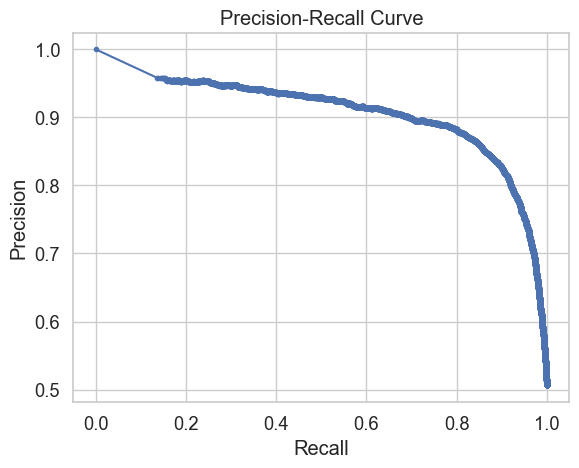

Average Precision Score: 0.9047250979322045


In [94]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)


y_pred_prob = naive_bayes_classifier.predict_proba(X_test_vectorized)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test_encoded, y_pred_prob)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


average_precision = average_precision_score(y_test_encoded, y_pred_prob)
print("Average Precision Score:", average_precision)

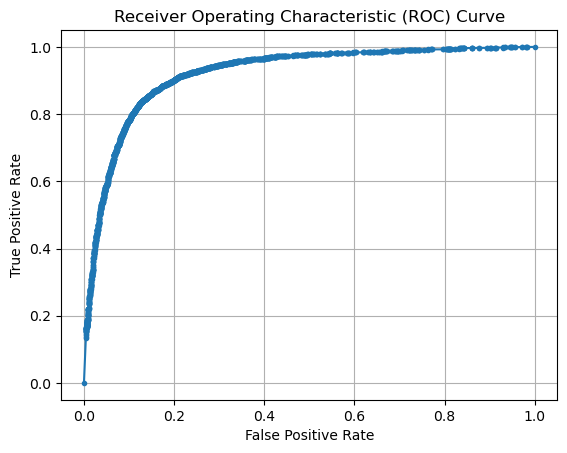

Area Under the ROC Curve (AUC): 0.9204277927965047


In [73]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer


label_binarizer = LabelBinarizer()
y_test_encoded = label_binarizer.fit_transform(y_test)


y_pred_prob = naive_bayes_classifier.predict_proba(X_test_vectorized)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_prob)


plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.grid(True)
plt.show()


roc_auc = roc_auc_score(y_test_encoded, y_pred_prob)
print("Area Under the ROC Curve (AUC):", roc_auc)